In [1]:
import os
os.chdir( "../")

In [2]:
rp3_best_params = {'topK': 29,
 'alpha': 0.33723025040409343,
 'beta': 0.15542352567862933,
 'normalize_similarity': True}

slimen_best_params = {'topK': 638, 'l1_ratio': 0.026639245044358113, 'alpha': 0.001535792379351249}



In [3]:
import psutil
num_cpus = psutil.cpu_count(logical=False)
num_cpus 


8

In [4]:
import pandas as pd
import numpy as np

path = "Dataset/data_train.csv"
df = pd.read_csv(filepath_or_buffer=path,
                               sep=",",
                               header=1,
                               engine='python',
                               names=['UserID', 'ItemID', 'Interaction'])


df

,UserID,ItemID,Interaction
0,1,15,1.0
1,1,16,1.0
2,1,133,1.0
3,1,161,1.0
4,1,187,1.0
...,...,...,...
478724,13024,13605,1.0
478725,13024,13823,1.0
478726,13024,15122,1.0
478727,13024,18185,1.0


In [5]:
user_ids = df["UserID"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
item_ids = df["ItemID"].unique().tolist()
item2item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded2item = {i: x for i, x in enumerate(item_ids)}
df["User"] = df["UserID"].map(user2user_encoded)
df["Item"] = df["ItemID"].map(item2item_encoded)

num_users = len(user2user_encoded)
num_items = len(item_encoded2item)
df["Interaction"] = df["Interaction"].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = 0.0
max_rating = max(df["Interaction"])

print(
    "Number of users: {}, Number of Items: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_items, min_rating, max_rating
    )
)

Number of users: 12638, Number of Items: 22222, Min rating: 0.0, Max rating: 1.0


In [6]:
userId_unique = df["UserID"].unique()
itemId_unique = df["ItemID"].unique()

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
import scipy.sparse as sps
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

seeds = [
    1811854, 3772146, 6407100, 6926227, 1340378, 
    68679, 3822303, 4058970, 1264160, 1100338, 
    6552126, 725363, 8362134, 9446122, 5256199, 
    4686339, 3830906, 7315366, 9428914, 5564236, 
    3420043, 9223036, 851434, 3300082, 7899660, 
    2053768, 4305274, 3709256, 8795594, 1418903, 
    7428566, 157832
]

seeds = seeds[:num_cpus]

urm_all = sps.coo_matrix((df["Interaction"].values, 
                          (df["User"].values, df["Item"].values)))

urm_train_validation = []
urm_test = []
urm_train = []
urm_validation = []

for i in range(len(seeds)):
    a, b = split_train_in_two_percentage_global_sample(urm_all, train_percentage = 0.80,seed=seeds[i])
    c, d = split_train_in_two_percentage_global_sample(a, train_percentage = 0.80,seed=seeds[i])
    urm_train_validation.append(a)
    urm_test.append(b)
    urm_train.append(c)
    urm_validation.append(d)



In [8]:
from Recommenders.Recommender_import_list import *
from Recommenders.MatrixFactorization.ImplicitIALSRecommender import ImplicitALSRecommender
from Recommenders.Incremental_Training_Early_Stopping import Incremental_Training_Early_Stopping
from concurrent.futures import ProcessPoolExecutor

recommenderClass = SLIMElasticNetRecommender
earlystopping_keywargs = {}

def build_fold(fold, **hyperparams):
    recommender = recommenderClass(urm_train_validation[fold], verbose=True)
    epochs = -1
    if issubclass(recommenderClass, ImplicitALSRecommender):
        recommender.fit(
            use_gpu=True,
            num_threads=1,
            **hyperparams
        )

    elif issubclass(recommenderClass, Incremental_Training_Early_Stopping):
        ea_args = {**earlystopping_keywargs}
        ea_args["evaluator_object"] = ea_args["evaluator_object"][fold]
        recommender.fit(**hyperparams, **ea_args)
        epochs = recommender.get_early_stopping_final_epochs_dict()["epochs"]
    else:
        recommender.fit(**hyperparams)

    recommender.save_model("/home/japo/RecSys-Challenge/result_experiments_more_data/Hybrids/", recommender.RECOMMENDER_NAME + "_split_" + str(fold) + ".zip")
    return 1

def prepare_models(fold, hyperparameters):
    return build_fold(fold, **hyperparameters)

#with ProcessPoolExecutor(max_workers=num_cpus) as executor:
            # Submit all tasks to the process pool and wait for them to complete
            #fold_results = list(executor.map(lambda fold: run_fold(fold, **current_fit_hyperparameters_dict), range(len(seeds))))
#    fold_results = list(executor.map(prepare_models, range(len(seeds)), [slimen_best_params]*len(seeds)))

2024-01-04 22:16:42.689277: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-04 22:16:42.689447: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
num_users = len(userId_unique)
num_items = len(itemId_unique)

In [10]:
from Recommenders.Recommender_import_list import *
from Evaluation.Evaluator import EvaluatorHoldout

evaluator_validation = []
for u in urm_validation:
    evaluator_validation.append(EvaluatorHoldout(u, cutoff_list=[10], ignore_users=[]))

EvaluatorHoldout: Ignoring 2565 (20.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users
EvaluatorHoldout: Ignoring 2625 (20.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users
EvaluatorHoldout: Ignoring 2596 (20.5%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users
EvaluatorHoldout: Ignoring 2666 (21.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users
EvaluatorHoldout: Ignoring 2621 (20.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users
EvaluatorHoldout: Ignoring 2652 (21.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users
EvaluatorHoldout: Ignoring 2570 (20.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users
EvaluatorHoldout: Ignoring 2646 (20.9%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users


In [11]:
from Evaluation.Evaluator import EvaluatorHoldout
evaluator_test = []
for u in urm_test:
    evaluator_test.append(EvaluatorHoldout(u, cutoff_list=[10], ignore_users=[]))

EvaluatorHoldout: Ignoring 2166 (17.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users
EvaluatorHoldout: Ignoring 2150 (17.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users
EvaluatorHoldout: Ignoring 2190 (17.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users
EvaluatorHoldout: Ignoring 2194 (17.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users
EvaluatorHoldout: Ignoring 2165 (17.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users
EvaluatorHoldout: Ignoring 2145 (17.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users
EvaluatorHoldout: Ignoring 2171 (17.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users
EvaluatorHoldout: Ignoring 2198 (17.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users


In [12]:
import os

output_folder_path = "result_experiments_more_data/"

# If directory does not exist, create
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)
    
n_cases = 500  # using 10 as an example
n_random_starts = int(n_cases*0.3)
metric_to_optimize = "MAP"   
cutoff_to_optimize = 10

In [13]:
from HyperparameterTuning.SearchAbstractClass import SearchInputRecommenderArgs
from HyperparameterTuning.SearchBayesianSkopt import SearchBayesianSkopt

from HyperparameterTuning.run_hyperparameter_search import runHyperparameterSearch_Collaborative, runHyperparameterSearch_Content
from Recommenders.NonPersonalizedRecommender import TopPop, Random
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
import os, multiprocessing
from functools import partial
from skopt.space import Real, Integer, Categorical


In [14]:
earlystopping_keywargs = {"validation_every_n": 5,
                          "stop_on_validation": True,
                          "evaluator_object": evaluator_validation,
                          "lower_validations_allowed": 5,
                          "validation_metric": metric_to_optimize,
                          }

In [15]:
from concurrent.futures import ProcessPoolExecutor
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
import time
from Recommenders.Incremental_Training_Early_Stopping import Incremental_Training_Early_Stopping

In [16]:
n_points = 10000
n_jobs = 1  # Using all available CPUs
acq_func = 'gp_hedge'
acq_optimizer = 'auto'
verbose = True
n_restarts_optimizer = 10
xi = 0.01
kappa = 1.96
x0 = None
y0 = None
noise = 1e-5
random_state = int(os.getpid() + time.time()) % np.iinfo(int).max
model_counter=0

In [17]:
rp3_Ws = []
slim_Ws = []
for i in range(len(seeds)):
    rp3 = RP3betaRecommender(urm_train[i],verbose=True)
    rp3.load_model("result_experiments_more_data/Hybrids", rp3.RECOMMENDER_NAME + "_split_" + str(i) + ".zip")
    W = rp3.W_sparse
    #W = (W - W.min()) / (W.max() - W.min())
    rp3_Ws.append(W)

    slim = SLIMElasticNetRecommender(urm_train[i], verbose=True)
    slim.load_model("result_experiments_more_data/Hybrids", slim.RECOMMENDER_NAME + "_split_" + str(i) + ".zip")
    W = slim.W_sparse
    #W = (W - W.min()) / (W.max() - W.min())
    slim_Ws.append(W)

RP3betaRecommender: URM Detected 481 ( 3.8%) users with no interactions.
RP3betaRecommender: URM Detected 320 ( 1.4%) items with no interactions.
RP3betaRecommender: Loading model from file 'result_experiments_more_data/HybridsRP3betaRecommender_split_0.zip'
RP3betaRecommender: Loading complete
SLIMElasticNetRecommender: URM Detected 481 ( 3.8%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 320 ( 1.4%) items with no interactions.
SLIMElasticNetRecommender: Loading model from file 'result_experiments_more_data/HybridsSLIMElasticNetRecommender_split_0.zip'


SLIMElasticNetRecommender: Loading complete
RP3betaRecommender: URM Detected 453 ( 3.6%) users with no interactions.
RP3betaRecommender: URM Detected 346 ( 1.6%) items with no interactions.
RP3betaRecommender: Loading model from file 'result_experiments_more_data/HybridsRP3betaRecommender_split_1.zip'
RP3betaRecommender: Loading complete
SLIMElasticNetRecommender: URM Detected 453 ( 3.6%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 346 ( 1.6%) items with no interactions.
SLIMElasticNetRecommender: Loading model from file 'result_experiments_more_data/HybridsSLIMElasticNetRecommender_split_1.zip'
SLIMElasticNetRecommender: Loading complete
RP3betaRecommender: URM Detected 446 ( 3.5%) users with no interactions.
RP3betaRecommender: URM Detected 355 ( 1.6%) items with no interactions.
RP3betaRecommender: Loading model from file 'result_experiments_more_data/HybridsRP3betaRecommender_split_2.zip'
RP3betaRecommender: Loading complete
SLIMElasticNetRecommender: URM De

In [18]:
from Recommenders.MatrixFactorization.ImplicitIALSRecommender import ImplicitALSRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender

recommenderClass = ItemKNNSimilarityHybridRecommender

hyperparameters_range_dictionary = {
        "topK": Integer(5, 300),
        "alpha": Real(low = 0.2651626829923486, high = 0.37644615066224263, prior = 'uniform'),
        "beta": Real(low = 0, high = 1.35, prior = 'uniform'),
        "normalize_similarity": Categorical([True, False]),
        #"implicit" : Categorical([True])
}

hyperparameters_range_dictionary = {
    "topK": Integer(5, 1000),
    "alpha" : Real(low = 0 , high=1, prior = 'uniform') 
}


#hyperparameters_range_dictionary = {
#                "topK": Integer(5, 1000),
#                "l1_ratio": Real(low = 1e-5, high = 1.0, prior = 'log-uniform'),
#                "alpha": Real(low = 1e-3, high = 1.0, prior = 'uniform'),
#            }

#IALS
#hyperparameters_range_dictionary = {
#                "num_factors": Integer(1, 500),
#                "epochs": Integer(50,2500),
#                "confidence_scaling": Categorical(["linear", "log"]),
#                "alpha": Real(low = 1e-3, high = 50.0, prior = 'log-uniform'),
#                "epsilon": Real(low = 1e-3, high = 10.0, prior = 'log-uniform'),
#                "reg": Real(low = 1e-5, high = 1e-2, prior = 'log-uniform'),
#            }

hyperparameters_range_dictionary

{'topK': Integer(low=5, high=1000, prior='uniform', transform='identity'),
 'alpha': Real(low=0, high=1, prior='uniform', transform='identity')}

In [19]:
if issubclass(recommenderClass, Incremental_Training_Early_Stopping):
    print("Using EarlyStop")

In [20]:
from concurrent.futures import ProcessPoolExecutor
import os

import multiprocessing
from skopt import dump
from skopt.callbacks import CheckpointSaver

# Define a function to save your optimization after every `n` calls
def checkpoint_saver(n_calls=10, checkpoint_path="checkpoint.pkl"):
    return CheckpointSaver(checkpoint_path, compress=9) # keyword arguments will be passed to `skopt.dump`

print(f"RUNNING ON {num_cpus} threads")

sum_map = lambda results: sum(item[metric_to_optimize] for item in results)

hyperparams = dict()
hyperparams_names = list()
hyperparams_values = list()

skopt_types = [Real, Integer, Categorical]

for name, hyperparam in hyperparameters_range_dictionary.items():
    if any(isinstance(hyperparam, sko_type) for sko_type in skopt_types):
        hyperparams_names.append(name)
        hyperparams_values.append(hyperparam)
        hyperparams[name] = hyperparam

columns = ["Fold",metric_to_optimize]
for h in hyperparams_names:
    columns.append(h)

fold_results_df = pd.DataFrame(columns=columns)
if os.path.exists(output_folder_path + recommenderClass.RECOMMENDER_NAME + "_folds_results.csv"):
    fold_results_df = pd.read_csv(output_folder_path + recommenderClass.RECOMMENDER_NAME + "_folds_results.csv")


def run_fold(fold, **hyperparams):
    # Fit the model on this fold and return the evaluation metric
    # ...
    
    if issubclass(recommenderClass, ItemKNNSimilarityHybridRecommender):
        recommender = recommenderClass(urm_train_validation[fold], rp3_Ws[fold], slim_Ws[fold], verbose=True)
    else:
        recommender = recommenderClass(urm_train_validation[fold], verbose=True)
    epochs = -1

    if issubclass(recommenderClass, ImplicitALSRecommender):
        recommender.fit(
            use_gpu=True,
            num_threads=1,
            **hyperparams
        )
    elif issubclass(recommenderClass, Incremental_Training_Early_Stopping):
        ea_args = {**earlystopping_keywargs}
        ea_args["evaluator_object"] = ea_args["evaluator_object"][fold]
        recommender.fit(**hyperparams, **ea_args)
        epochs = recommender.get_early_stopping_final_epochs_dict()["epochs"]        
    else:
        recommender.fit(**hyperparams)

    result, _ = evaluator_test[fold].evaluateRecommender(recommender)
    metric_result = result[metric_to_optimize].item()
    
    print(f"Fold {fold}: hyperparams {hyperparams}, ended with {metric_to_optimize} {metric_result}")

    return {'Fold': fold, metric_to_optimize: metric_result, 'epochs': epochs, **hyperparams}

def run_fold_wrapper(fold, hyperparameters):
    return run_fold(fold, **hyperparameters)


def evaluate_model(hyperparams):

    global fold_results_df

    current_fit_hyperparameters_dict = dict(zip(hyperparams_names, hyperparams))

    if issubclass(recommenderClass, ImplicitALSRecommender):
        fold_results=[]
        for i, seed in  enumerate(seeds):
            fold_results.append(run_fold(i, **current_fit_hyperparameters_dict))
    else:
        # Start the process pool
        with ProcessPoolExecutor(max_workers=num_cpus) as executor:
            # Submit all tasks to the process pool and wait for them to complete
            #fold_results = list(executor.map(lambda fold: run_fold(fold, **current_fit_hyperparameters_dict), range(len(seeds))))
            fold_results = list(executor.map(run_fold_wrapper, range(len(seeds)), [current_fit_hyperparameters_dict]*len(seeds)))


    print(fold_results)
    for res in fold_results:
        fold_results_df = pd.concat([fold_results_df, pd.DataFrame([res])], ignore_index=True)
    fold_results_df.to_csv(output_folder_path + recommenderClass.RECOMMENDER_NAME + "_folds_results.csv")

    # Compute average score across all folds
    average_score = sum_map(fold_results) / len(fold_results)

    print(f"Finished trial with Average {metric_to_optimize}: {average_score}")

    return -average_score  # Assuming a score that needs to be minimized




from skopt import load
checkpointPath = output_folder_path + recommenderClass.RECOMMENDER_NAME +"_checkpoint.pkl"
print(checkpointPath)
checkpoint_callback = checkpoint_saver(n_calls=1, checkpoint_path=checkpointPath)

if os.path.exists(checkpointPath):
    res = load(checkpointPath)
    #UNCOMMENT TO RESTART LAST CHECKPOINT
    x0 = res.x_iters
    y0 = res.func_vals
    model_counter = len(res.x_iters)
    res.fun

print(f"Still need to run {n_cases - model_counter} trials")

result = gp_minimize(evaluate_model, hyperparams_values,
                     base_estimator=None,
                     n_calls=max(0, n_cases - model_counter),
                     n_initial_points= max(0, n_random_starts - model_counter),
                     initial_point_generator = "random",
                     acq_func=acq_func,
                     acq_optimizer=acq_optimizer,
                     x0=x0,
                     y0=y0,
                     random_state=random_state,
                     verbose=verbose,
                     callback=[checkpoint_callback],
                     n_points=n_points,
                     n_restarts_optimizer=n_restarts_optimizer,
                     xi=xi,
                     kappa=kappa,
                     noise=noise,
                     n_jobs=1
                    )

RUNNING ON 8 threads
result_experiments_more_data/ItemKNNSimilarityHybridRecommender_checkpoint.pkl
Still need to run 298 trials
Iteration No: 1 started. Evaluating function at random point.


KeyboardInterrupt: 

In [22]:
import pandas as pd
result = load(output_folder_path + recommenderClass.RECOMMENDER_NAME +"_checkpoint.pkl")
results_df = pd.DataFrame(result.x_iters, columns=[dim for dim in hyperparameters_range_dictionary])
results_df['score'] = result.func_vals

In [26]:
results_df[results_df['score'] < -0.0511]

,topK,alpha,score
23,633,0.449743,-0.051112
34,897,0.377093,-0.051128
43,614,0.417391,-0.051117
49,836,0.370906,-0.051124
85,733,0.468356,-0.051123
96,594,0.415192,-0.051116
111,944,0.439190,-0.051111
135,910,0.351179,-0.051112
138,640,0.434983,-0.051115
144,955,0.396083,-0.051118


In [24]:
newdict = dict()
for key in results_df[results_df["score"] == results_df["score"].min()].drop(columns=["score"]):
    newdict[key] = results_df[results_df["score"] == results_df["score"].min()][key].item()
newdict

{'topK': 1000, 'alpha': 0.446039762079027}

In [ ]:
SLIMEN = {'topK': 530, 'l1_ratio': 0.05017569359096808, 'alpha': 0.001}
P3ALPHA = {'topK': 400, 'alpha': 1.6632815179401539, 'normalize_similarity': True}
RP3 = {'topK': 71, 'alpha': 0.31274648571776065, 'beta': 0.3586324430664178, 'normalize_similarity': True}

SLIMEN_KFOLD = {'Fold': 0, 'MAP': 0.029228665181843458, 'topK': 660, 'l1_ratio': 0.0012296801858497721, 'alpha': 0.001}
RP3_KFOLD = {'topK': 34,
 'alpha': 0.28453879172230406,
 'beta': 0.15344052347036438,
 'normalize_similarity': True}
IMPLICIT_IALS = {'num_factors': 128,
 'epochs': 478,
 'confidence_scaling': 'linear',
 'alpha': 3.358295366834473,
 'epsilon': 7.295986722921583,
 'reg': 6.292360640597378e-05}

In [ ]:
#BEST 100 SINGLE SPLIT: 0.030123825632990115
OLD_BEST_PARAMS = {'topK': 34, 'alpha': 0.37644615066224263, 'beta': 0.16604377135619697, 'normalize_similarity': True}

# 0.030008733292970144
OLD_BEST_PARAMS = {'topK': 59,
 'alpha': 0.3764461506622426,
 'beta': 0.10277510174112,
 'normalize_similarity': True}

#0.030128708347317946
OLD_BEST_PARAMS = {'topK': 34,
 'alpha': 0.28453879172230406,
 'beta': 0.15344052347036438,
 'normalize_similarity': True}

old_res = 0
for i in range(len(seeds)):
    m = recommenderClass(urm_train[i])
    m.fit(**OLD_BEST_PARAMS)
    ris, _ = evaluator_validation[i].evaluateRecommender(m)
    old_res += ris["MAP"].item()
old_res = old_res / len(seeds)
old_res

RP3betaRecommender: URM Detected 481 ( 3.8%) users with no interactions.
RP3betaRecommender: URM Detected 320 ( 1.4%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 8617.41 column/sec. Elapsed time 2.58 sec
EvaluatorHoldout: Processed 10073 (100.0%) in 2.34 sec. Users per second: 4304
RP3betaRecommender: URM Detected 453 ( 3.6%) users with no interactions.
RP3betaRecommender: URM Detected 346 ( 1.6%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 8584.56 column/sec. Elapsed time 2.59 sec
EvaluatorHoldout: Processed 10013 (100.0%) in 2.34 sec. Users per second: 4283
RP3betaRecommender: URM Detected 446 ( 3.5%) users with no interactions.
RP3betaRecommender: URM Detected 355 ( 1.6%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 8529.22 column/sec. Elapsed time 2.61 sec
EvaluatorHoldout: Processed 10042 (100.0%) in 2.25 sec. Users per second: 4469
RP3betaRecommender: URM Detected 450 

0.030008733292970144

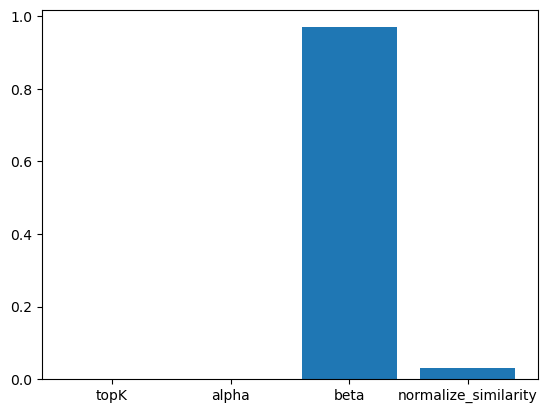

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


regr = RandomForestRegressor(max_depth=2)

result_df_graph = results_df.copy()
result_df_graph["score"] *= -1

numerical_cols = result_df_graph.mean().notna()
numerical_cols = numerical_cols.index[numerical_cols]

numerical_df = result_df_graph[numerical_cols]
numerical_df = (numerical_df - numerical_df.mean())/(numerical_df.std() +1e-6)

y_train = numerical_df["score"]
X_train = numerical_df.copy()
X_train = X_train.drop(columns=["score"])

regr.fit(X_train, y_train)

plt.bar(X_train.columns, regr.feature_importances_)
plt.show() 

In [ ]:
final_model = ItemKNNSimilarityHybridRecommender(urm_all)